<a href="https://colab.research.google.com/github/jiwoong2/deeplearning/blob/main/GAN%EC%97%90_%EB%8C%80%ED%95%9C_%EC%9D%B4%ED%95%B4%EC%99%80_%ED%95%99%EC%8A%B5%EA%B3%BC%EC%A0%95_%EC%8B%9C%EA%B0%81%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PCA와 Kernel density estimation를 활용한 데이터 분포 시각화.

gan논문에서는 생성모델의 성능을 평가하기위해 Gaussian Parzen window를 활용해 추정한 생성데이터의 밀도함수에 원본데이터 샘플을 적용해 구한 log-우도를 활용한다.

또, 논문에서는 충분한 용량과 시간이 있다면 이론적으로 생성모델이 임의의 노이즈분포를 원본데이터분포에 완전히 맵핑시키는 global optimum이 존재한다고 이야기한다.

이번 프로제트에서는 위의 두 내용에서 아이디어를 얻어 PCA와 Kernel density estimation을 활용하여 원본데이터의 밀도함수를 3D그래프로 시각화하고 GAN을 학습시키며 얻은 생성모델들의 생성데이터의 밀도함수 또한 같은 방식으로 시각화하여 원본데이터와 생성데이터의 분포를 비교하고 학습이 진행함에따라 생성데이터의 분포가 어떻게 변화하는지 시각화하고자한다.

# 순서

1. GAN 학습 및 생성모델 저장.
2. 원본데이터의 밀도함수를 3D그래프로 시각화.
3. 학습이 완료된 생성모델이 생성한 데이터의 밀도함수를 3D그래프로 시각화.
4. 원본데이터의 밀도함수와 생성한 데이터의 밀도함수 그래프 비교
5. 학습이 진행되며 변화하는 그래프 비교.

# GAN 학습 및 생성모델 저장.

In [6]:
import os
import numpy as np
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from google.colab import drive
drive.mount('/content/drive')

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Mounted at /content/drive


In [ ]:
# 이미지 저장용 폴더 생성, exist_ok는 해당경로에 같은파일이 이미존재해도 오류를 일으키지 않게함.
os.makedirs("/content/drive/MyDrive/Colab Notebooks/gan/mnist", exist_ok=True)
os.makedirs("/content/drive/MyDrive/Colab Notebooks/gan/gen_imgs", exist_ok=True)

In [7]:
n_epochs = 200  # 학습 에폭 수
batch_size = 64  # 배치 크기
lr = 0.0002  # 학습률
b1 = 0.5  # adam 최적화기의 베타1 값
b2 = 0.999  # adam 최적화기의 베타2 값
n_cpu = 8  # 배치 생성 시 사용할 CPU 쓰레드 수
latent_dim = 100  # 잠재 공간의 차원 수
img_size = 28  # 이미지의 한 변의 크기
channels = 1  # 이미지의 채널 수
sample_interval = 400  # 이미지 샘플링 간격

img_shape = (channels, img_size, img_size)

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        def block(in_dim, out_dim, normalize=True):
            layers = [nn.Linear(in_dim, out_dim)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_dim, momentum=0.8)) # eps는 분모에추가되어 0으로 나누는것을 방지,
                                                             # momentum: 새로운 값과 이전 실행 평균 및 분산에 대한 가중치를 조절하는데 사용되는 값, 기본값은 0.1.
            layers.append(nn.LeakyReLU(0.2, inplace=True)) # 0.2는 LeakyReLU의 음수값 기울기, inplace는 입력텐서를 바로수정해 메모리절약.
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), # 배치정규화를 사용하지 않는 이유는?
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape) # 이미지 shape 변경.
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512), # np.prod는 곱.
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat) # validity는 타당성.
        return validity

In [10]:
# 손실함수.
adversarial_loss = nn.BCELoss() # 이진 크로스 엔트로피

# 모델 및 손실함수 초기화.
generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)
adversarial_loss = adversarial_loss.to(DEVICE)

In [ ]:
# Configure data loader 데이터로더 구성.
os.makedirs("/content/drive/MyDrive/Colab Notebooks/gan/mnist/data/mnist", exist_ok=True)
dataloader = DataLoader(
    datasets.MNIST(
        "/content/drive/MyDrive/Colab Notebooks/gan/mnist/data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose( # 데이터 변환을 조합. 리사이즈, 텐서변환, 노말라이즈(0.5빼기 0.5나누기. 0에서 1사이의 값을 -1에서 1사이의 값을 변경.)
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size,
    shuffle=True,
)

In [11]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [ ]:
# Training
for epoch in range(n_epochs): # 입력에폭만큼 반복
    for i, (imgs, _) in enumerate(dataloader): # 인덱스와 이미지

        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1, device=DEVICE) # 배치 묶음만큼 행으로하는 1로채워진 텐서
        fake = torch.zeros(imgs.size(0), 1, device=DEVICE)

        # Configure input
        real_imgs = imgs.type(torch.Tensor).to(DEVICE) #이미지의 데이터형을 텐서로 변경

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad() # 그라디언트 초기화

        # Sample noise as generator input
        z = torch.randn(imgs.shape[0], latent_dim, device=DEVICE) # 가우시안분포에서 노이즈 생성 latent_dim은 노이즈벡터의 차원

        # Generate a batch of images
        gen_imgs = generator(z) # 가짜이미지 생성

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid) # valil 실제이미지인척!

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]"
        )

    # 에폭마다 이미지 저장
    save_image(gen_imgs.data[:25], f"/content/drive/MyDrive/Colab Notebooks/gan/gen_imgs/{epoch}.png", nrow=5, normalize=True)
    torch.save(generator, f'/content/drive/MyDrive/Colab Notebooks/model/gan{epoch}.pt')

# 원본데이터의 밀도함수를 3D그래프로 시각화.

In [2]:
# PyTorch에서 MNIST 데이터 로드
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=1000, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 35343818.48it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 19403442.87it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32089027.55it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10455833.57it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [46]:
imgs = []

for img, label in data_loader:
    # label이 0인 이미지만 처리합니다.
    # img = img[label == 0]
    img = img.flatten(1)
    imgs.append(img.numpy())

imgs = np.concatenate(imgs, axis=0)

print(imgs.shape)

(60000, 784)


In [47]:
# 축소 및 밀도 추정
pca = PCA(n_components=2)
data_pca = pca.fit_transform(np.stack(imgs))
data_pca.shape

kde = gaussian_kde(data_pca.T) # gaussian_kde를 사용하기위해서 transpose

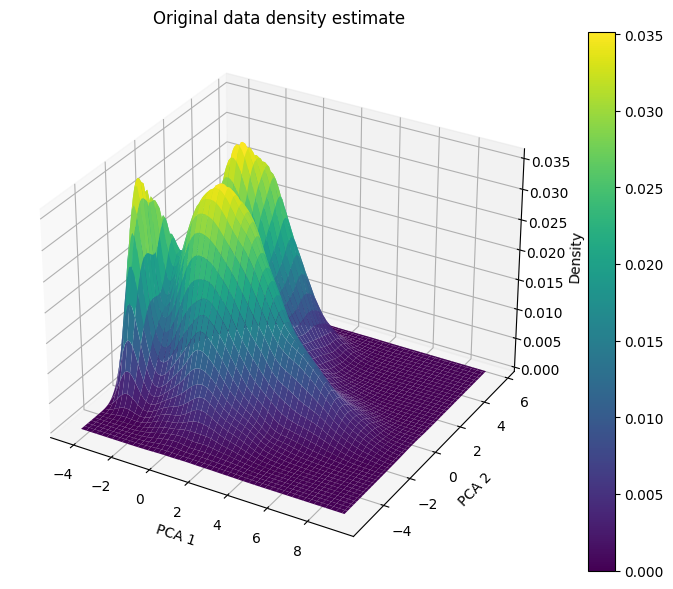

In [48]:
# 2차원 그리드 생성
x = np.linspace(data_pca[:, 0].min(), data_pca[:, 0].max(), 100)
y = np.linspace(data_pca[:, 1].min(), data_pca[:, 1].max(), 100)
X, Y = np.meshgrid(x, y)

# 그리드 상의 각 지점에서 밀도 계산
positions = np.vstack([X.ravel(), Y.ravel()])
density = kde(positions).reshape(X.shape)

# 3차원 그래프로 시각화
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, density, cmap='viridis', edgecolor='none')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('Density')
plt.title('Original data density estimate')
plt.colorbar(surf)
plt.show()

# 학습이 완료된 생성모델이 생성한 데이터의 밀도함수를 3D그래프로 시각화.

In [13]:
# 모델 인스턴스 생성
generator = Generator()

In [14]:
# 모델 로드 (이전에 저장된 모델의 경로를 지정하세요)
model_path = '/content/drive/MyDrive/Colab Notebooks/model/gan198.pt'
generator = torch.load(model_path, map_location=torch.device('cpu'))  # CPU로 매핑. GPU로 저장한 모델을 로드할때 필요.
generator.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [49]:
# 노이즈벡터 생성
z = torch.randn(20000, latent_dim)

# 노이즈벡터를 입력받아 이미지생성.
gen_imgs = generator(z)

In [50]:
# 밀도추정으루이해 이미지를 벡터로 변환.
gen_imgs = gen_imgs.flatten(1)

In [51]:
# 차원축소와 밀도추정을위해 gradient추적을 멈추고 넘파이배열로 반환.
gen_imgs = gen_imgs.detach()
gen_imgs = gen_imgs.numpy()
gen_imgs.shape

(20000, 784)

In [52]:
# 축소 및 밀도 추정
pca = PCA(n_components=2)
gen_imgs_pca = pca.fit_transform(np.stack(gen_imgs))
gen_imgs_pca.shape

kde = gaussian_kde(gen_imgs_pca.T)

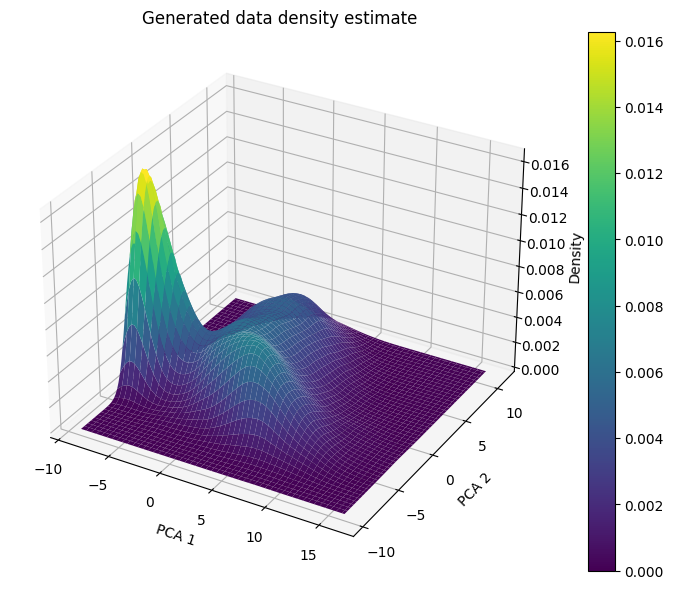

In [53]:
# 2차원 그리드 생성
x = np.linspace(gen_imgs_pca[:, 0].min(), gen_imgs_pca[:, 0].max(), 100)
y = np.linspace(gen_imgs_pca[:, 1].min(), gen_imgs_pca[:, 1].max(), 100)
X, Y = np.meshgrid(x, y)

# 그리드 상의 각 지점에서 밀도 계산
positions = np.vstack([X.ravel(), Y.ravel()])
density = kde(positions).reshape(X.shape)

# 3차원 그래프로 시각화
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, density, cmap='viridis', edgecolor='none')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('Density')
plt.title('Generated data density estimate')
plt.colorbar(surf)
plt.show()

# 원본데이터의 밀도함수와 생성한 데이터의 밀도함수 그래프 비교

원본데이터와 생서데이터의 밀도분포를 비교해보면 예상과 다르게 상이하다는것을 알 수 있다. 프로젝트 구상시 완전히 일치하지는 않아도 어느정도 비슷할거라고 생각했었기에 상당히 실망스러운 결과다.

문제점을 생각해보면 일단 논문에서 제시한 이론과 다르게 현시에서는 모델을 완전히 학습시키는 것이 불가능 하다는 것 이다.

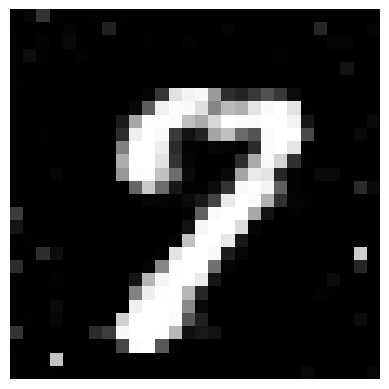

In [68]:
# 학습이 완료된 모델이 생성한 이미지.

z = torch.randn(1, latent_dim)
z = generator(z)

def imshow(img_tensor):
    img = img_tensor.squeeze()  # 차원 축소: [1, 1, 28, 28] -> [28, 28]
    img = img.detach()
    plt.imshow(img, cmap='gray')  # 흑백 이미지로 출력
    plt.axis('off')  # 축 제거
    plt.show()

# 이미지 출력
imshow(z)

PCA를 이용한 차원 축소 또한 문제가 될 수 있다. MNIST data는 벡터로표현하면 784차원의 데이터다. 고차원 데이터의 밀도를 시각화하기위해 차원을 축소하는 과정에서 필연적으로 정보손실이 발생하며 이는 데이터의 차원이 높을수록 심각한 문제가 될 것 이다.


Kernel density estimation에 대해 생각해보면 고차원 데이터에 Kernel density estimation를 적용해 밀도를 추정하는것은 신뢰도가 떨어지지만 PCA로 차원을 축소 했고 축소하는 과정에서 데이터 분포에 대한 표현력이 현격이 떨어졌을 가능성이 크지만 그 자체에대한 분포는 잘 표현했으리라 생각된다.

만약 고차원 데이터를 축소하면서도 그 분포특성을 충분히 유지할수 있는 차원축소방법이 있다면 이를 이용한 차원 축소와 밀도추정을 시도해볼수 있을 것 이다.

# 학습이 진행되며 변화하는 그래프 비교.